In [132]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split #from model_selection instead of cross_validation
from sklearn.model_selection import validation_curve #from model_selection instead of learning_curve
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [133]:
np.random.seed(42)

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
def plot_curve(sizes, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(sizes, mu, '-', **kwargs)
    plt.fill_between(sizes, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.3)
    
def normalize_data(df, columns):
    for column in columns:
        mean_value = df.loc[:,column].mean()
        stdev = np.std(df.loc[:,column].values)
        df.loc[:,column] = (df.loc[:,column] - mean_value) / stdev
    return df

data and DecisionTreeClassifier import

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


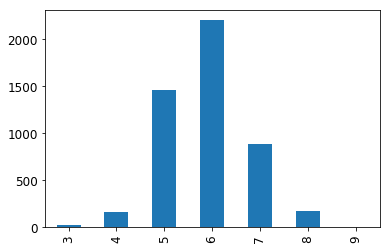

In [134]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
#df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
df = pd.read_csv(url, sep=';')
column_list = list(df.columns)[0:-1]
#print (df.head())
print (column_list)
df.quality.value_counts().sort_index().plot(kind = 'bar')

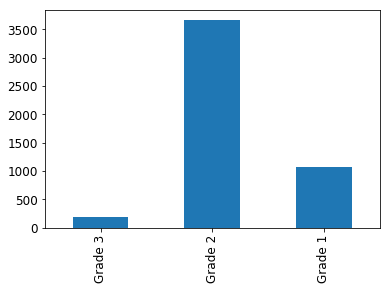

In [135]:
df['grade'] = np.array(['Grade 1' if i>=7 else 'Grade 2' if i>=5 else 'Grade 3' for i in df['quality']])
#df.grade.value_counts().plot(kind = 'bar')
#df.grade.value_counts().plot(kind = 'bar')
df.grade.value_counts().sort_index(ascending=False).plot(kind = 'bar')
target = 'grade'

In [136]:
X = df[column_list].values
#print (X[:3])
y = df[target].values

In [137]:
df = normalize_data(df, column_list)
df.describe().T
X = df[column_list].values
#shuffle data
X, y = shuffle(X, y, random_state=23)
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

# DecisionTreeClassifier

In [138]:
dt_clf = DecisionTreeClassifier(max_depth = 8, random_state=0)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.76666666666666672

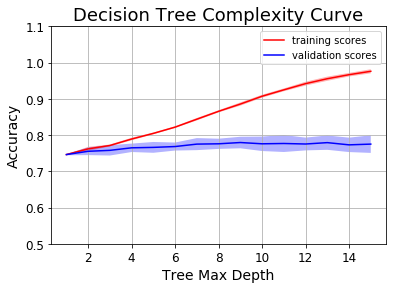

In [98]:
depths = np.arange(1, 16)
val_train, val_test = validation_curve(DecisionTreeClassifier(random_state=0), 
                                       X_train, y_train,
                                       'max_depth', depths, cv=10)
def plot_with_depth(depths, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(depths, mu, '-', **kwargs)
    plt.fill_between(depths, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.3)

plot_curve(depths, val_train, label='training scores', color = 'r')
plot_curve(depths, val_test, label='validation scores', color = 'b')
plt.ylim(0.5, 1.1)
plt.xlabel('Tree Max Depth'); plt.ylabel('Accuracy')
plt.title('Decision Tree Complexity Curve', fontsize=18)
plt.legend()
plt.grid()

In [ ]:
def plot_complexity_curve_dt():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="max_depth"
    param_range=range(1,16)
    val_train, val_test = validation_curve(DecisionTreeClassifier(random_state=0),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('Tree Max Depth (max_depth)'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Complexity Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_dt()

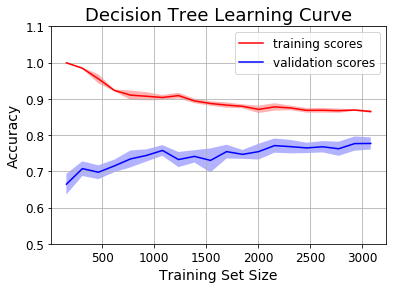

In [140]:
def plot_learning_curve_dt():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=8),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_learning_curve_dt()

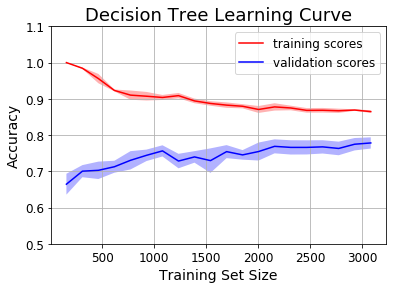

In [141]:
def plot_learning_curve_dt():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=8),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10, scoring='accuracy')
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_learning_curve_dt()

# MLPClassifier

In [146]:
# mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
#                         hidden_layer_sizes=(10, 2), max_iter = 200,random_state=0)
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                        hidden_layer_sizes=10, max_iter = 100,random_state=0)
mlp_clf.fit(X_train, y_train)
mlp_clf.score(X_test, y_test)

0.77755102040816326

In [ ]:
def plot_complexity_curve_mlp1():
    param_name="hidden_layer_sizes"
    param_range=range(1,51)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_mlp1()

In [ ]:
def plot_complexity_curve_mlp2():
    param_name="max_iter"
    param_range=[1, 3, 10, 32, 100, 320, 1000, 3200]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('LOG10(Max Iterations(max_iter))'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve', fontsize=18)
    plt.legend(fontsize=12)
    plt.grid()
    
plot_complexity_curve_mlp2()

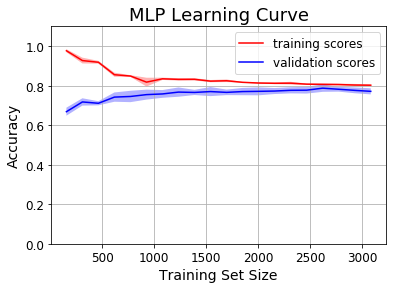

In [148]:
def plot_learning_curve_mlp():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e-5, 
                        hidden_layer_sizes=10, max_iter = 100, random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0, 1.1)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve', fontsize=18)
    plt.legend(fontsize=12)
    plt.grid()
    
plot_learning_curve_mlp()

# AdaBoostClassifier

In [88]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=8),
    n_estimators=1000,
    learning_rate=1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)
bdt_clf.score(X_test, y_test)

0.84965986394557824

In [ ]:
def plot_complexity_curve_bdt():
    param_name="n_estimators"
    param_range=range(10, 100, 10)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost (DecisionTree) Complexity Curve', fontsize=18)    
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_bdt()

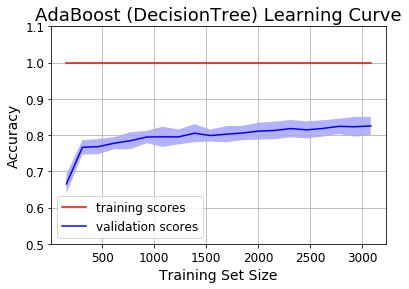

In [149]:
def plot_learning_curve_bdt():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=8),
                                                                     n_estimators=60,learning_rate=1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 80)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost (DecisionTree) Learning Curve', fontsize=18)    
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_learning_curve_bdt()

# SVC

In [ ]:
# svm_clf = SVC(kernel='linear', C=1)
# svm_clf.fit(X, y)

In [7]:
# svm_clf = SVC(kernel='linear', C=1)
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.74625850340136057

In [41]:
# svm_clf = SVC(kernel='linear', C=1)
#svm_clf = SVC(kernel='rbf', C=100, gamma='auto')
svm_clf = SVC(kernel='rbf', C=10, gamma=1)
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.83469387755102042

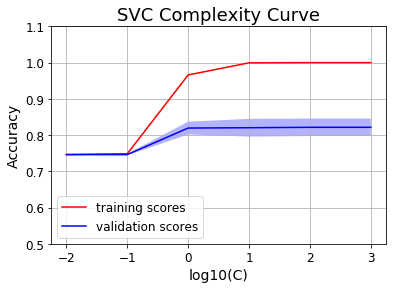

In [150]:
def plot_complexity_curve_svm1():
    param_name="C"
    param_range=[0.01, 0.1, 1, 10, 100, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf', gamma = 1),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_svm1()

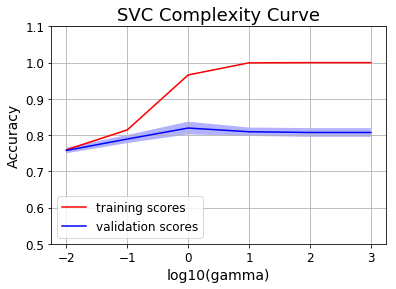

In [151]:
def plot_complexity_curve_svm2():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.1, 1, 10, 100, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf', C = 1),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    #plt.xlim(5, 800)
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_svm2()

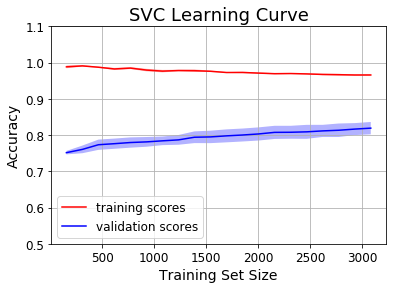

In [152]:
def plot_learning_curve_svm():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'rbf', C = 1, gamma = 1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_learning_curve_svm()

# KNN

In [130]:
knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.76938775510204083

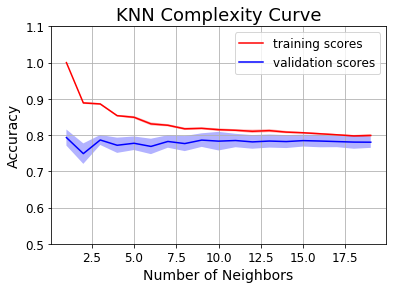

In [153]:
def plot_complexity_curve_knn():
    param_name="n_neighbors"
    param_range=range(1, 20)
    val_train, val_test = validation_curve(KNeighborsClassifier(),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    plt.xlabel('Number of Neighbors (n_neighbors)'); plt.ylabel('Accuracy')
    plt.title('KNN Complexity Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_complexity_curve_knn()

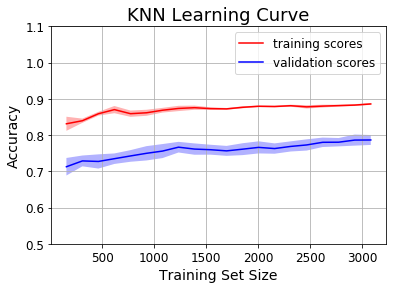

In [154]:
def plot_learning_curve_knn():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(KNeighborsClassifier(n_neighbors=3),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    plt.ylim(0.5, 1.1)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('KNN Learning Curve', fontsize=18)
    plt.legend(fontsize = 12)
    plt.grid()
    
plot_learning_curve_knn()